In [1]:
import gymnasium as gym
import math
import os
import random
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import time

from IPython.display import clear_output

# os.environ["SDL_VIDEODRIVER"] = "dummy"

env = gym.make("CartPole-v1", render_mode='rgb_array')
env.action_space.seed(42)

[42]

## Test Environment

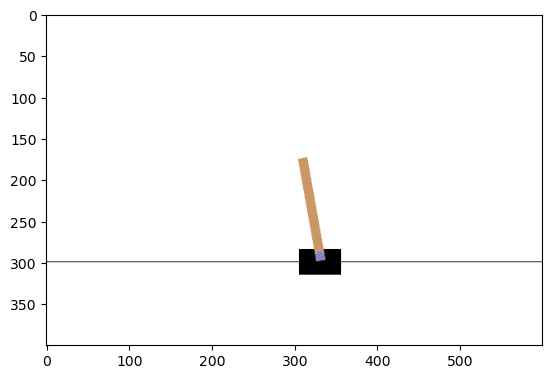

In [2]:
observation, info = env.reset(seed=42)

for _ in range(100):
    observation, reward, done, info, _ = env.step(env.action_space.sample())

    if done:
        break

    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

env.close()

## Q-learning

#### Create config

In [56]:
config = {'lr': 0.1,
          'gamma': 0.95,
          'eps1': 1,
          'eps2': 0.001,
          'decays': 20000}
decay = np.exp(np.log(config['eps2'] / config['eps1']) / config['decays'])

#### Discretize the states

In [57]:
n_bins = 20
bins = [np.linspace(-2.4, 2.4, n_bins),
        np.linspace(-4, 4, n_bins),
        np.linspace(-.2095, .2095, n_bins),
        np.linspace(-4, 4, n_bins)
    ]

def digitize_state(state):
    stateIndex = []
    for i in range(len(bins)):
        stateIndex.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(stateIndex)

In [58]:
n_actions = env.action_space.n
Q = np.zeros(tuple([n_bins] * len(bins)) + (n_actions,))

#### Policy function

In [59]:
def policy(state):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    return np.argmax(Q[state])

#### One episode

In [60]:
def run_episode():
    tot_rew = 0 # total reward
    state, info = env.reset() # start state
    dis_state = digitize_state(state)
    while True:
        action = policy(dis_state) # choose an action
        observation, reward, terminated, truncated, info = env.step(action)
        next_dis_state = digitize_state(observation)
    
        TD = reward + config['gamma'] * np.max(Q[next_dis_state]) - Q[dis_state + (action, )]
        Q[dis_state + (action, )] += config['lr'] * TD

        tot_rew += reward
        
        if terminated or truncated:
            return tot_rew

        dis_state = next_dis_state

0.11748975549391448


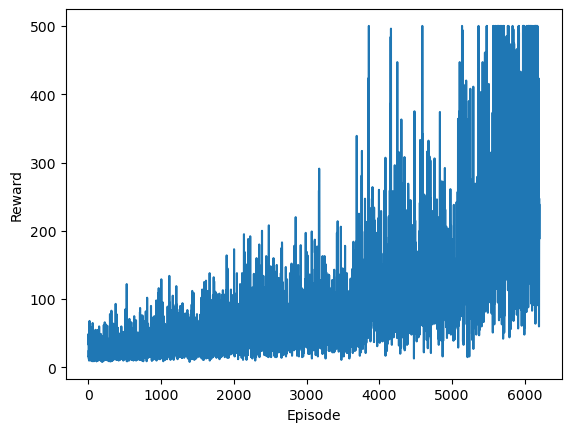

In [ ]:
epsilon = config['eps1']
episodes = 100000
log = {'episode': [], 'rewards': []}
for episode in range(1, episodes+1):
    r = run_episode()
    log['rewards'].append(r)
    log['episode'].append(episode)

    epsilon *= decay
    if epsilon < config['eps2']:
        epsilon = 0.
    if episode % 100 == 0:
        clear_output(wait=True)
        print(epsilon)
        plt.plot(log['episode'], log['rewards'])
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.show()